In [60]:
### libraries for the usage
import numpy as np 
import math 
import sys 
import pandas as pd 
import glob
from numpy import linalg as lng
import seaborn as sns
from modules import Interaction,Files,Observable
import matplotlib.pyplot as plt

### Number density calculations

In [61]:
#def intham(mc_kagome,temp):
"""
    Initializing the interacting part of the hamiltonian given the 
    non-interacting hamiltonian
"""
#    for j in range(10):
#        noint_copy = mc_kagome.ham.copy()
#        intmat = mc_kagome.intpart(mc_kagome.datadf, noint_copy, j)
 #       evlsi, evcsi = lng.eigh(intmat)
  #      observ = Observable(evlsi,evcsi,temp)
  #      be = observ.fermiFunc()
   #     observ.feCe(4)
    #    print(observ.n)

#def main():
"""
This is the main program this calls intham subroutine to initialize
the interacting hamiltonian for different monte carlo configurations
"""

#def init_param():
# number of unit cell in x direction
l_cell = int(12)  

# total number of unit cells
n_cell = int(l_cell**2)

# number of sites in the unit cell
s_cell = int(3)  

# total number of site (for one spin type)
n_sites = int(s_cell*n_cell)  

# hopping strength
hopping = 1.0   

# dimensionality of the matrix
dim_h = int(2*n_sites)

# chemical potential
mu = 13.47

# interaction strength
u_int = 9.0  

# temperature
temp = 0.30

## file path were the files are stored
file_path = './'
## pattern we want to search in the file name
pattern = f'mc*L{l_cell}*Uint{u_int}*.dat'

## get the file names of files inside the folder
file_dict = Files.getFiles(file_path, pattern)


### create the object
mc_kagome = Interaction(l_cell, n_cell, s_cell, hopping, n_sites,
                        dim_h, mu, u_int)


### set up the non-interacting hamiltonian
mc_kagome.neighbour()  # set up the neighbour table
mc_kagome.haminit() # set the non interacting hamiltonian

###generate mx,my,mx given m,theta,phi
datadf = mc_kagome.datadf(temp, file_dict)
datadf['temp'] = temp

## initialize the non interacting hamiltonian
## ham is the non-interacting hamiltonian

## initializing an empty dataframe to store eigenvalue for all the 
## monte carlo configurations
eval_df = pd.DataFrame()
fermi_func = pd.DataFrame()
density_df = pd.DataFrame()
n_d = []
for j in range(5):
    nointmat = mc_kagome.ham.copy()

    mat = mc_kagome.intpart(datadf,nointmat,j)
    evls,evec = lng.eigh(mat)
    eval_df = pd.concat([eval_df,pd.Series(evls,name=f'conf{j}')],axis=1)

    density = Observable(temp,evls,evec)
    
    density.fermiFunc()
    fermi_func = pd.concat([fermi_func,pd.Series(density.be/(1+density.be),name=f'conf{j}')],axis=1)
    density.n_sites = mc_kagome.n_sites
    n_di = []
    for k in range(density.n_sites):
        density.densitycalc(k)
        n_di.append(density.n.real)
    density_df = pd.concat([density_df,pd.Series(n_di,name=f'conf{j}')],axis=1)

#if __name__ == "__main__":
#   main()


#init_param()


In [62]:
density_df.describe()

,conf0,conf1,conf2,conf3,conf4
count,432.000000,432.000000,432.000000,432.000000,432.000000
mean,0.510657,0.510268,0.509197,0.506809,0.506809
std,0.091067,0.094118,0.094228,0.094943,0.094943
min,0.154937,0.154945,0.154909,0.155312,0.155312
25%,0.471846,0.469908,0.469926,0.469688,0.469688
50%,0.506157,0.506320,0.505122,0.502533,0.502533
75%,0.545725,0.547803,0.546225,0.541506,0.541506
max,0.918719,0.918719,0.918719,0.918720,0.918720


In [63]:
density_df.mean()

conf0    0.510657
conf1    0.510268
conf2    0.509197
conf3    0.506809
conf4    0.506809
dtype: float64

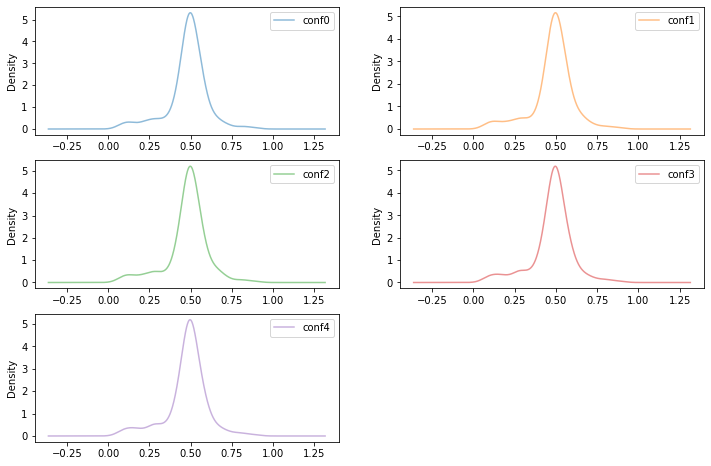

In [59]:
density_df.plot(kind='density',figsize=(12,8),subplots=True, \
                layout=(3, 2), alpha=0.5, xlabel='n', ylabel='H(n)',sharex=False)

plt.show()


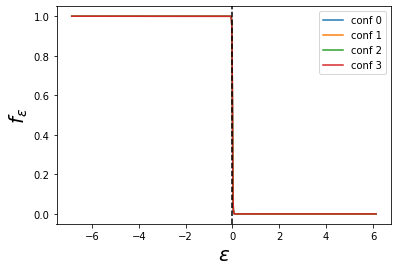

In [22]:
def plotFermifunc(dffermi,df_enr,t=5):
    f=plt.figure()
    for j in range(t):
        plt.plot(df_enr.iloc[:,j],dffermi.iloc[:,j],label=f'conf {j}')
    plt.axvline(x=0,color='black',linestyle='--')
    plt.xlabel(r'$\epsilon$',fontsize=20)
    plt.ylabel(r'$f_{\epsilon}$',fontsize=20)
    plt.legend()
    plt.show()
plotFermifunc(fermi_func,eval_df,4)

### Density of states
Density of states can be obtained simply by storing all the eigenvalues for different configurations into a dataframe. The dataframe can be converted into a series by concatenating each column to the series. A histogram of the data will give the density of states.


In [23]:
def enrConcat(df):
    """
    This function will take a dataframe as an input and give a 1d series of all the energies
    parameters:
        df(dataframe): dataframe with energy for different configuration as column
    return:
        allenr(series): all the energies into a series
    """
    allenr = pd.Series(dtype='float')
    for j in eval_df.columns:
        allenr = pd.concat([allenr,df.loc[:,j]])
    return allenr
allenr = enrConcat(eval_df)

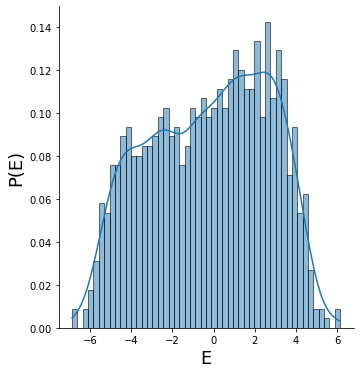

In [24]:
sns.displot(allenr,kde=True,stat='density',bins=50)
plt.xlabel('E',fontsize=18)
plt.label('P(E)',fontsize=18)

plt.show()